# Inteligencia artificial

# Clase 11 - Optimizadores
## Exploracion de modelos

Como lo hicimos las clases anteriores, vamos a definir una función que nos permita instanciar un modelo secuencial a partir de los parámetros que recibe. En este caso podremos configurar la **arquitectura** (cantidad de capas y cantidad de neuronas por capa), el tamaño de los datos de entrada y el **optimizador**.


Importamos la clase `Sequential` y las capas `Dense` y `Flatten` con las que vamos a construir el modelo.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### El dataset

In [15]:
# Cargamos el dataset
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [16]:
# Evaluamos las shapes de train y test
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [17]:
# Especificamos los nombres de cada clase
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

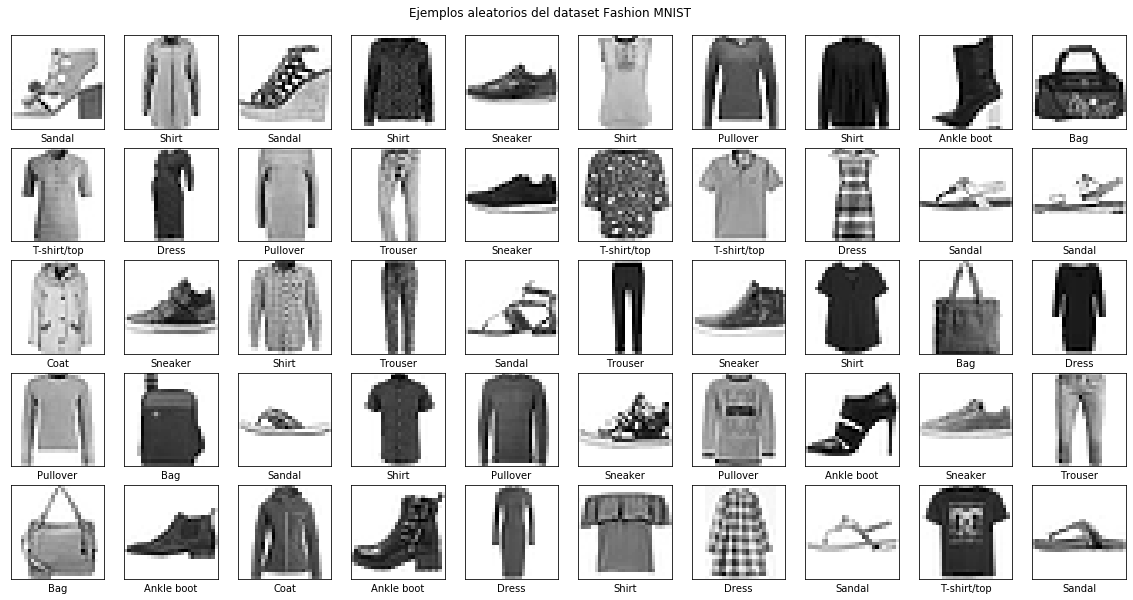

In [18]:
# Visualizamos algunas de las imágenes contenidas en el dataset
plt.figure(figsize=(20, 10))
plt.suptitle('Ejemplos aleatorios del dataset Fashion MNIST', y=0.92)

for i, j in enumerate(np.random.choice(x_train.shape[0], 50)):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[j], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[j]])
plt.show()

In [19]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [20]:
x_train = x_train / 255
x_test = x_test / 255

In [21]:
def build_model(input_shape=(28,28), layers=[64,64,10], optimizer='rmsprop'):
    # Instanciamos la clase del modelo secuencial
    model = Sequential()
    # Aplanamos los datos de entrada, sabemos que vamos a recibir imágenes
    model.add(Flatten(input_shape=input_shape))
    # Agregamos el resto de las capas con activación ReLU con excepción de la última
    for l in layers[:-1]:
        model.add(Dense(units=l, activation='relu'))
    # Agregamos la última capa con activación softmax
    model.add(Dense(units=layers[-1], activation='softmax'))
    # Compilamos el modelo con el optimizador seleccionado
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # Retornamos el modelo compilado
    return model

Construimos un modelo de ejemplo

In [22]:
model = build_model(layers=[32, 32, 10])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


La estructura de la red se ajusta a lo indicado en el argumento `layers`.

**Desafío:** modificar la función `build_model` para que admita capas intermedias de normalización.

Ahora usaremos cross validation para encontrar la mejor configuración de la red y del optimizador.

In [24]:
from keras import optimizers

In [25]:
# Definimos la "grilla" de parámetros que vamos a explorar
layers = [[512, 10],
          [64, 32,10]
         ]
optimizers = [optimizers.Adam(), optimizers.SGD(momentum=0.9, nesterov=True)]

Ahora debemos generar las combinaciones entre las posibilidades de ambos parámetros.

In [26]:
import itertools
combinaciones = list(itertools.product(layers, optimizers))
combinaciones

[([512, 10], <keras.optimizers.Adam at 0x7f9e3820d410>),
 ([512, 10], <keras.optimizers.SGD at 0x7f9e4471b790>),
 ([64, 32, 10], <keras.optimizers.Adam at 0x7f9e3820d410>),
 ([64, 32, 10], <keras.optimizers.SGD at 0x7f9e4471b790>)]

In [27]:
# Definamos algunas variables
n_splits = 3
batch_size = 256
epochs = 20
verbose = 1

In [28]:
# Creamos una lista vacía para ir guardando los entrenamientos
global_history = []

In [29]:
# Importamos KFold para hacer cross-validation
from sklearn.model_selection import KFold

# Instanciamos el objeto KFold
kfold = KFold(n_splits=n_splits, shuffle=False)

# Recorremos las combinaciones y generamos distintos modelos a ensayar
for (layers, optimizer) in combinaciones:
    print('\n\nEnsayando modelo con estructura {} y optimizador {}'.format(layers, optimizer))
    
    # Construimos el modelo
    model = build_model(layers=layers, optimizer=optimizer)
    
    # Guardamos los pesos iniciales para usarlos en cada fold
    model.save_weights('initial_weights.h5')
    
    # Generamos los sets de train y val para ensayar el modelo
    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
        # Reiniciamos los pesos del modelo
        model.load_weights('initial_weights.h5')
        
        # Lo entrenamos con el split de x_train e y_train correspondiente
        history = model.fit(x=x_train[train_idx],
                            y=y_train[train_idx],
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_train[val_idx], y_train[val_idx]),
                            verbose=verbose
                           )
        
        # Evaluamos en train y en val (estos mismos valores los podemos sacar de history)
        train_loss, train_acc = model.evaluate(x_train[train_idx], y_train[train_idx])
        val_loss, val_acc = model.evaluate(x_train[val_idx], y_train[val_idx])
        
        # Agregamos esta corrida a la historia global
        global_history.append({'fold':fold, 
                               'layers':layers, 
                               'optimizer':optimizer,
                               'train_loss':train_loss,
                               'train_acc':train_acc,
                               'val_loss':val_loss,
                               'val_acc':val_acc,
                               'history':history
                              })



Ensayando modelo con estructura [512, 10] y optimizador <keras.optimizers.Adam object at 0x7f9e3820d410>
Train on 40000 samples, validate on 20000 samples
Epoch 1/20
40000/40000 [==============================] - 1s 24us/step - loss: 0.6103 - accuracy: 0.7897 - val_loss: 0.4616 - val_accuracy: 0.8377
Epoch 2/20
40000/40000 [==============================] - 1s 16us/step - loss: 0.4243 - accuracy: 0.8510 - val_loss: 0.4015 - val_accuracy: 0.8587
Epoch 3/20
40000/40000 [==============================] - 1s 17us/step - loss: 0.3759 - accuracy: 0.8688 - val_loss: 0.3767 - val_accuracy: 0.8656
Epoch 4/20
40000/40000 [==============================] - 1s 17us/step - loss: 0.3482 - accuracy: 0.8761 - val_loss: 0.3637 - val_accuracy: 0.8698
Epoch 5/20
40000/40000 [==============================] - 1s 16us/step - loss: 0.3291 - accuracy: 0.8837 - val_loss: 0.3714 - val_accuracy: 0.8650
Epoch 6/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.3062 - accuracy: 0.8909 - v

In [30]:
import pandas as pd
df = pd.DataFrame(global_history)
df.head()

,fold,layers,optimizer,train_loss,train_acc,val_loss,val_acc,history
0,0,"[512, 10]",<keras.optimizers.Adam object at 0x7f9e3820d410>,0.173549,0.937025,0.315794,0.89045,<keras.callbacks.callbacks.History object at 0...
1,1,"[512, 10]",<keras.optimizers.Adam object at 0x7f9e3820d410>,0.179039,0.934450,0.317117,0.89020,<keras.callbacks.callbacks.History object at 0...
2,2,"[512, 10]",<keras.optimizers.Adam object at 0x7f9e3820d410>,0.180863,0.931275,0.330964,0.88515,<keras.callbacks.callbacks.History object at 0...
3,0,"[512, 10]",<keras.optimizers.SGD object at 0x7f9e4471b790>,0.322904,0.886875,0.380774,0.86500,<keras.callbacks.callbacks.History object at 0...
4,1,"[512, 10]",<keras.optimizers.SGD object at 0x7f9e4471b790>,0.318677,0.886250,0.363715,0.87225,<keras.callbacks.callbacks.History object at 0...


Queda por cuenta de ustedes analizar los resultados y sacar conlusiones sobre los modelos y optimizadores ensayados.